# Develop a sentiment classifier for a kind of texts of your choice 

# Install packages



In [ ]:
!pip install kaggle --upgrade
!pip install --upgrade tensorflow
!pip install keras-self-attention

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 511.7 MB 6.7 kB/s 
     |████████████████████████████████| 1.6 MB 48.9 MB/s 
     |████████████████████████████████| 5.8 MB 51.3 MB/s 
     |████████████████████████████████| 438 kB 69.5 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
  Attempting uninstall: gast
    Found ex

# Imports

In [ ]:
# numpy stack
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# general
import re
import os
from string import digits
import time

# nltk
import nltk
from nltk.util import ngrams
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# Sklearn
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, auc, precision_recall_curve, f1_score, classification_report, accuracy_score, confusion_matrix, roc_auc_score
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import RandomizedSearchCV, cross_validate


# scipy
from scipy import sparse

#  word embeddings
import gensim.downloader as GensimDownloader
from gensim.models import Word2Vec, KeyedVectors

# plt.style
plt.style.use('default')

# inline to include plots
%matplotlib inline


# Kaggle

In [ ]:
os.environ['KAGGLE_USERNAME'] = 'giannislakkas'
os.environ['KAGGLE_KEY'] = '9181860ede8d79ed87da011b601b71aa'

# Kaggle
from kaggle.api.kaggle_api_extended import KaggleApi

def load_dataset():
  api = KaggleApi()
  api.authenticate()
  !kaggle competitions download -c twitter-sentiment-analysis2
  !mkdir twitter
  !unzip twitter-sentiment-analysis2.zip -d twitter  

try:
  if os.path.exists('twitter/test.csv'):
    print('files exists, proceeding')
  else:
    load_dataset()
except:
  load_dataset()

 62% 9.00M/14.6M [00:01<00:00, 5.99MB/s]
100% 14.6M/14.6M [00:01<00:00, 10.3MB/s]
Archive:  twitter-sentiment-analysis2.zip
  inflating: twitter/test.csv        
  inflating: twitter/train.csv       


# Downloads

In [ ]:
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Download Dataset

* We opted for the [Twitter Sentiment Analysis Dataset](https://www.kaggle.com/c/twitter-sentiment-analysis2/data). In order to load the file, the kaggle.json file need to be uploaded when prompted.

* The dataset consists of a train and test set, which will be added to a `./twitter` folder.

# Load files

* For this exercise and due to RAM constrains in Google Colab we used the `train.csv` and loaded the file into a DataFrame, which will be later be used for the train/dev/test split. 

In [ ]:
data = pd.read_csv('./twitter/train.csv', delimiter=',',  encoding="latin-1")

data.drop(columns='ItemID', inplace=True)
data.shape

(99989, 2)

In [ ]:
data.head()

,Sentiment,SentimentText
0,0,is so sad for my APL frie...
1,0,I missed the New Moon trail...
2,1,omg its already 7:30 :O
3,0,.. Omgaga. Im sooo im gunna CRy. I'...
4,0,i think mi bf is cheating on me!!! ...


* Let's see how balanced the targets are:

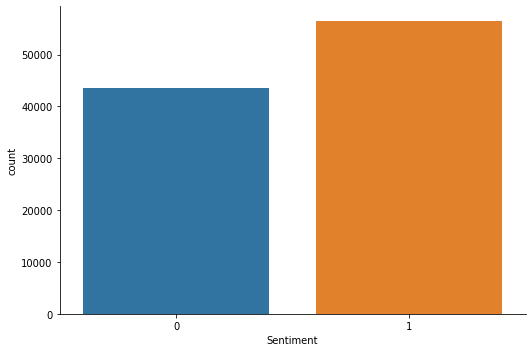

In [ ]:
_ = sns.catplot(x='Sentiment',data=data,kind='count',height=5,aspect=1.5)

# Pre-processing

* Having downloaded our data, we will perform a set of pre-processing steps, in order to bring the text to a "clean" format. More details, regarding the steps, are added as comments in the function `preprocess`.

In [ ]:
# initialize lemmatizer
stemmer = WordNetLemmatizer()

# define trans for digits
remove_digits = str.maketrans('', '', digits)

Below are some examples of some additional cases that need to be included since we are working with tweets: 
1. Twitter usernames (@user)
2. Websites (Http)

In [ ]:
print("Tweet with user tag:\t", data[data['SentimentText'].str.contains("@")==True].SentimentText.iloc[0])
print("Tweet with website:\t", data[data['SentimentText'].str.contains("http")==True].SentimentText.iloc[0])

Tweet with user tag:	       hmmmm.... i wonder how she my number @-)
Tweet with website:	     awhhe man.... I'm completely useless rt now. Funny, all I can do is twitter. http://myloc.me/27HX


In [ ]:
def preprocess(sentence):
    """
    Function to process a given sentence.
    INPUT: raw string (tweet)
    OUTPUT: processed string 
    """
    #convert the sentence to lower
    sentence = sentence.lower()
    
    # Remove underscores 
    sentence = re.sub(r'[-_]', '', sentence)
    sentence = re.sub(r'_[A-Za-z0-9]+', ' ', sentence)
    sentence = re.sub(r'^ _\s+', ' ', sentence)

    # Remove twitter usernames
    sentence = re.sub(r'@\w+', ' ', sentence)

    # Remove websites
    sentence = re.sub('https?://[A-Za-z0-9./]+', ' ', sentence)

    #remove all non words
    sentence = re.sub(r'\W', ' ', sentence)

    #remove all single characters
    sentence = re.sub(r'\b\w\b', ' ', sentence)

    # Remove numbers
    sentence = re.sub(r'[0-9]', ' ', sentence)
    sentence = sentence.translate(remove_digits)

    #remove multiple whitespaces
    sentence = re.sub(' +', ' ', sentence)

    # Split the sentence based on whitespaces (--> List of words)
    sentence = sentence.split()
    
    # Lemmatization
    sentence = [stemmer.lemmatize(word) for word in sentence]
    
    # Reconstruct the sentence by joining the words on each whitespace
    sentence = ' '.join(sentence)
    return sentence

In [ ]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.


True

* We will apply the `preprocess` function to the dataset and keep the results in a new column to have an overview of the results.

In [ ]:
data['text']= data['SentimentText'].apply(lambda row: preprocess(row))
data.head()

,Sentiment,SentimentText,text
0,0,is so sad for my APL frie...,is so sad for my apl friend
1,0,I missed the New Moon trail...,missed the new moon trailer
2,1,omg its already 7:30 :O,omg it already
3,0,.. Omgaga. Im sooo im gunna CRy. I'...,omgaga im sooo im gunna cry ve been at this de...
4,0,i think mi bf is cheating on me!!! ...,think mi bf is cheating on me tt


# Train/Dev/Test split

* Now that the the dataset has been pre-processed we can split the data into a Train, Dev and Test set. We followed the following strategy:
* A train/test split of 0.7/0.3 ratio, respectively, will initially take place. The output will be saved in the following variables:
`X_train_total` & `X_test`.
* Given that we will use NNs we need a development set thus will split the `X_train_total` variable into two other variables, `X_train` & `X_dev` with a 70/30 split. 
* The `X_train_total` variable will be used to train the model using cross-validation later on.

In [ ]:
# Define X, y
X, y  = data['text'], data['Sentiment']

# Define Train/Dev/Test split
X_train_total, X_test, y_train_total, y_test = train_test_split(X, y, test_size=0.3, stratify=y, shuffle=True, random_state=42)

# Extract a part of the train set as dev set
X_train, X_dev, y_train, y_dev = train_test_split(X_train_total, y_train_total, test_size=0.3, stratify=y_train_total, shuffle=True, random_state=42)

In [ ]:
print(f"""{'Train size:':<12} {X_train.shape[0]:>6}
{'Dev size:':<12} {X_dev.shape[0]:>6}
{'Test size:':<12} {X_test.shape[0]:>6}""")

Train size:   48994
Dev size:     20998
Test size:    29997


# Classification

* The following part demonstrates our solution for the classification task. Instead of using various features, we used the TF-IDF features and experimented with various NN models. There are three pillar to the analysis:
1. `DummyClassifier`: A classifier that assigns the most frequent class of the training data. The results obtained from the next methods will be compared to this one.
2. `LogisticRegression`: Two-class logistic regression classifier, using sklearn. Given that we used a slightly different dataset we will re-train the model.
3. `Neural networks`: We will build various NNs, with a variety of hidden layers.
4. `RNN`: We will build two RNNs, with a variety of attention score layers.

The first 3 were implemented in exercise 3.

## RNN Neural Network

### Imports

* In this part of the assignment we built various networks, starting from simple ones, to more complex, in order to see how the change of the NN's compoment affects the results.

In [ ]:
import warnings
import sklearn.exceptions
warnings.filterwarnings("ignore", category = sklearn.exceptions.UndefinedMetricWarning)
warnings.simplefilter(action = 'ignore', category = FutureWarning)

from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import optimizers
from keras import backend as K
from keras.regularizers import l1, l2

### Functions

* Before proceeding with the models, we will define functions that are going to be needed in the following parts.

In [ ]:
def evaluate(clf, X_train, y_train, X_test, y_test):
  # Evaluate
  predictions = clf.predict(X_train)
  score = accuracy_score(y_train, predictions)
  print("Train accuracy: {:.2f}%".format(score*100))

  predictions_test = clf.predict(X_test)
  score = accuracy_score(y_test, predictions_test)
  print("Test accuracy: {:.2f}% \n".format(score*100))

  print('#Class 0 in Train dataset:', np.where(y_train == 0)[0].shape)
  print('#Class 1 in Train dataset:', np.where(y_train == 1)[0].shape)

  cm_test = confusion_matrix(y_test, predictions_test, normalize='pred')

  print("\nConfusion Matrix for test data:")
  disp = ConfusionMatrixDisplay(cm_test)
  _ = disp.plot()

In [ ]:
# Function for accuracy, loss (i.e. binary cross-entropy) and f1 score
def plot_history(history):
    fig = plt.figure(figsize = (20, 5))
    ax1 = fig.add_subplot(1, 3, 1)
    # Summarize history for accuracy
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('model accuracy')
    ax1.set_ylabel('accuracy')
    ax1.set_xlabel('epoch')
    ax1.legend(['train', 'dev'], loc = 'upper left')

    ax2 = fig.add_subplot(1, 3, 2)
    # Summarize history for loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('model loss')
    ax2.set_ylabel('loss')
    ax2.set_xlabel('epoch')
    ax2.legend(['train', 'devv'], loc = 'upper left')

    ax3 = fig.add_subplot(1, 3, 3)
    # Summarize history for loss
    ax3.plot(history.history['f1'])
    ax3.plot(history.history['val_f1'])
    ax3.set_title('model f1')
    ax3.set_ylabel('f1')
    ax3.set_xlabel('epoch')
    ax3.legend(['train', 'dev'], loc = 'upper left')

# Function for predicting the output and then returning the computed metric values
def print_evaluation(model, x_test, y_test):
    score = model.evaluate(x_test, y_test, verbose = 1, batch_size = 100)

    print('\nTest Binary_cross_entropy: %.4f' %  (score[0]))
    print('\nTest precision: %.4f' %  (score[1]))
    print('\nTest recall: %.4f' %  (score[2]))
    print('\nTest f1: %.4f' % (score[3]))
    print('\nTest accuracy: %.4f'% (score[4]))

# Function for calculating the recall   
def recall(y_true, y_pred):
    
    """
    Recall metric.
    Only computes a batch-wise average of recall.
    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

# Function for calculating the precision 
def precision(y_true, y_pred):
    
    """
    Precision metric.
    Only computes a batch-wise average of precision.
    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    Source
    ------
    https://github.com/fchollet/keras/issues/5400#issuecomment-314747992
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

# Function for calculating the f1-score based on the above functions for recall and precision 
def f1(y_true, y_pred):
    
    """Calculate the F1 score."""
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * ((p * r) / (p + r))

# Function for calculating the accuracy
def accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.round(y_pred)), axis=1)

In [ ]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OneHotEncoder

def all_scores(opt_model, x, y, which_set):

  y_pred = np.round(opt_model.predict(x))
  # For each class
  print("Scores for each class")
  print("Precision score for class 0:", round(precision_score(y, y_pred, average="binary", pos_label=0),4),"& Precision score for class 1:", round(precision_score(y, y_pred, average="binary", pos_label=1),4))
  print("Recall score for class 0:", round(recall_score(y, y_pred, average="binary", pos_label=0),4), "& Recall score for class 1:", round(recall_score(y, y_pred, average="binary", pos_label=1),4))
  print("F1 score for class 0:", round(f1_score(y, y_pred, average="binary", pos_label=0),4), "& F1 score for class 1:", round(f1_score(y, y_pred, average="binary", pos_label=1),4))
  print("AUC score for each class", round(roc_auc_score(y, y_pred, average=None),4))

  # Macro-averaged for all classes
  print("---------------------")
  print("Macro-averaged scores")
  print("Precision score:", round(precision_score(y, y_pred, average="macro"),4))
  print("Recall score:", round(recall_score(y, y_pred, average="macro"),4))
  print("F1 score:", round(f1_score(y, y_pred, average="macro"),4))
  print("AUC score:", round(roc_auc_score(y, y_pred, average="macro"),4))


  print(classification_report(y, y_pred))

  cm_test = confusion_matrix(y, y_pred)
  disp = ConfusionMatrixDisplay(cm_test)
  disp.plot()
  disp.ax_.set_title(which_set)

  print()

* For the reporting we have set the verbose to 0 for all functions in order to make this notebook more presentable. 
* If needed the various verbose parts can be changed to 1 in order to see more details.

In [ ]:
#from keras_tqdm import TQDMNotebookCallback
from keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf

es = EarlyStopping(
    monitor = 'val_loss', 
    mode = 'min',
    patience = 5,
    verbose = 0
)

## bi-directional stacked RNN (with GRU or LSTM cells)

**Download, unzip & load fasttext word embeddings**

In [ ]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
!gzip -d cc.en.300.vec.gz

--2022-06-18 17:31:36--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 172.67.9.4, 104.22.74.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1325960915 (1.2G) [binary/octet-stream]
Saving to: ‘cc.en.300.vec.gz’

cc.en.300.vec.gz    100%[===================>]   1.23G  13.5MB/s    in 1m 41s  

2022-06-18 17:33:18 (12.5 MB/s) - ‘cc.en.300.vec.gz’ saved [1325960915/1325960915]



**Mount gdrive to colab**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## FEATURES

**Load fasttext embeddings**

To load fasttext pre-trained embeddings more efficiently, we can read only once the embeddings file and save:

1. A 2D np-array for the embedding vectors
2. A dictionary that maps each word to the row index of its embedding on the 2D np-array

In [ ]:
import pickle
import numpy as np

idx = 0
vocab = {}
with open("cc.en.300.vec", 'r', encoding="utf-8", newline='\n',errors='ignore') as f:
    for l in f:
        line = l.rstrip().split(' ')
        if idx == 0:
            vocab_size = int(line[0]) + 2
            dim = int(line[1])
            vecs = np.zeros(vocab_size*dim).reshape(vocab_size,dim)
            vocab["__PADDING__"] = 0
            vocab["__UNK__"] = 1
            idx = 2
        else:
            vocab[line[0]] = idx
            emb = np.array(line[1:]).astype(np.float64)
            if (emb.shape[0] == dim):
                vecs[idx,:] = emb
                idx+=1
            else:
                continue

    pickle.dump(vocab,open("/content/gdrive/My Drive/fasttext_voc.pkl" ,'wb'))
    np.save("/content/gdrive/My Drive/fasttext.npy",vecs)
    # Free ram
    vecs = None
    vocab = None
    emb = None

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


**Load embeddings np-array and mapping dictionary**



In [ ]:
import pickle
import numpy as np

fasttext_embed = np.load("/content/gdrive/My Drive/fasttext.npy")
fasttext_word_to_index = pickle.load(open("/content/gdrive/My Drive/fasttext_voc.pkl", 'rb'))

In [ ]:
import gc

gc.collect()

130

In [ ]:
X_train.reset_index(inplace=True, drop=True)
X_test.reset_index(inplace=True, drop=True)
X_dev.reset_index(inplace=True, drop=True)
X_train

0             had load of fun and officially love my dress
1        yer know when woke up wa like noo it wa dream ...
2        how is it not the same note stupid composer ru...
3        oh read twilight in day and started new moon y...
4        that what you get for thinking but hey keep pr...
                               ...                        
48989    ha ha have to rush work tonight unfortunately ...
48990                  did you install fring in your sleep
48991    yes part of the evil master plan busy night bu...
48992               buy zopiclone on line get decent sleep
48993    don know don have any more fact you shot me do...
Name: text, Length: 48994, dtype: object

#### **Use spacy for sentence splitting & tokenization**

In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm',disable=["tagger", "parser","ner"])
from spacy.lang.en.stop_words import STOP_WORDS
nlp.add_pipe('sentencizer') 

X_train_tokenized = []
for idx in range(len(X_train)):
  doc = nlp(X_train[idx])
  tokens = []
  for sent in doc.sents:
    for tok in sent:
      if '\n' in tok.text or "\t" in tok.text or "--" in tok.text or "*" in tok.text or tok.text.lower() in STOP_WORDS:
        continue
      if tok.text.strip():  
        tokens.append(tok.text.replace('"',"'").strip())
  X_train_tokenized.append(tokens)

X_test_tokenized = []
for idx in range(len(X_test)):
  doc = nlp(X_test[idx])
  tokens = []
  for sent in doc.sents:
    for tok in sent:

      if '\n' in tok.text or "\t" in tok.text or "--" in tok.text or "*" in tok.text or tok.text.lower() in STOP_WORDS:
        continue
      if tok.text.strip():
        tokens.append(tok.text.replace('"',"'").strip())
  X_test_tokenized.append(tokens)

X_dev_tokenized = []
for idx in range(len(X_dev)):
  doc = nlp(X_dev[idx])
  tokens = []
  for sent in doc.sents:
    for tok in sent:

      if '\n' in tok.text or "\t" in tok.text or "--" in tok.text or "*" in tok.text or tok.text.lower() in STOP_WORDS:
        continue
      if tok.text.strip():
        tokens.append(tok.text.replace('"',"'").strip())
  X_dev_tokenized.append(tokens)

/usr/local/lib/python3.7/dist-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_WORDS = 100000
MAX_SEQUENCE_LENGTH = 256
EMBEDDING_DIM = fasttext_embed.shape[1]

# Keras tokenizer uses \s for separating tokens
tokenizer = Tokenizer(num_words=MAX_WORDS,oov_token='__UNK__')
tokenizer.fit_on_texts([" ".join(x) for x in X_train_tokenized])
train_seqs = tokenizer.texts_to_sequences([" ".join(x) for x in X_train_tokenized])
test_seqs = tokenizer.texts_to_sequences([" ".join(x) for x in X_test_tokenized])
dev_seqs = tokenizer.texts_to_sequences([" ".join(x) for x in X_dev_tokenized])
train_data = pad_sequences(train_seqs, maxlen=MAX_SEQUENCE_LENGTH,padding='post')
test_data = pad_sequences(test_seqs, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
dev_data = pad_sequences(dev_seqs, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

In [ ]:
print(train_data[349])

[   4 1039  820    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

In [ ]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 31131 unique tokens.


In [ ]:
embedding_matrix = np.zeros((MAX_WORDS+2, EMBEDDING_DIM))
for word, i in word_index.items():
    if i > MAX_WORDS:
            continue
    try:
        embedding_vector = fasttext_embed[fasttext_word_to_index[word],:]
        embedding_matrix[i] = embedding_vector
    except:
        pass

#### Tune the hyper-parameters 
(e.g., number of stacked RNNs, number of hidden layers in the self-attention MLP, dropout probability) on the development subset of your dataset.

**Create and train a BiLSTM + MLP model**

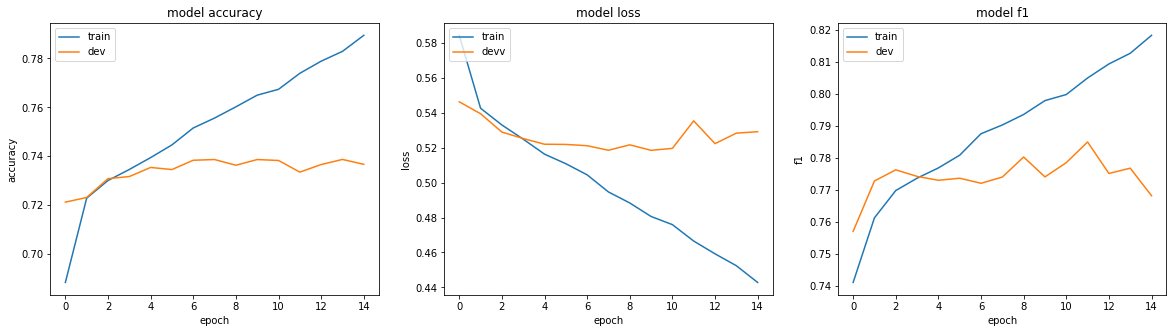

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Bidirectional, GRU, Embedding
from tensorflow.keras.optimizers import Adam
from keras_self_attention import SeqWeightedAttention


GRU_SIZE = 300
DENSE = 1000

with tf.device('/device:GPU:0'):

  # create empty sequential model
  model1 = Sequential()
  # add an embedding layer
  model1.add(Embedding(MAX_WORDS+2, EMBEDDING_DIM, weights=[embedding_matrix], 
                      input_length=MAX_SEQUENCE_LENGTH,mask_zero=True, trainable=False))
  # Use 0.33 dropout probabillity
  model1.add(Dropout(0.20))
  # add a bidirectional gru layer with 0.33 variational (recurrent) dropout 
  model1.add(Bidirectional(GRU(GRU_SIZE, recurrent_dropout = 0.20)))
  # dropout layer
  model1.add(Dropout(0.20))
  # add a hidden MLP layer
  model1.add(Dense(DENSE, activation='relu' ))
  # dropout layer
  model1.add(Dropout(0.20))
  # add the output MLP layer
  model1.add(Dense(1,  activation = 'sigmoid'))

  model1.compile(
   # Loss function to minimize
     loss = 'binary_crossentropy',
     optimizer = Adam(learning_rate = 0.001),
   # List of metrics to monitor
     metrics = [precision, recall, f1, accuracy]
  )

  RNN_model = model1.fit(
      train_data, 
      y_train.to_numpy(),
      batch_size = 1000,
      epochs = 50,
      verbose = 0,
      callbacks = [es], shuffle = True, validation_data=(dev_data, y_dev.to_numpy()))

  plot_history(RNN_model)

**Create and train a BiLSTM + linear self-attention + MLP model**

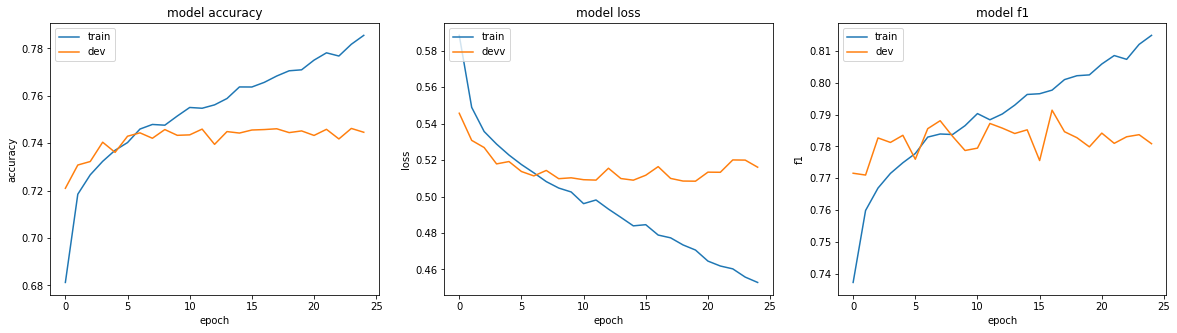

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Bidirectional, GRU, Embedding
from tensorflow.keras.optimizers import Adam
from keras_self_attention import SeqWeightedAttention


GRU_SIZE = 300
DENSE = 1000

with tf.device('/device:GPU:0'):

  # create empty sequential model
  model2 = Sequential()
  # add an embedding layer
  model2.add(Embedding(MAX_WORDS+2, EMBEDDING_DIM, weights=[embedding_matrix], 
                      input_length=MAX_SEQUENCE_LENGTH,mask_zero=True, trainable=False))
  # Use 0.33 dropout probabillity
  model2.add(Dropout(0.33))
  # add a bidirectional gru layer with 0.33 variational (recurrent) dropout 
  model2.add(Bidirectional(GRU(GRU_SIZE, return_sequences=True, recurrent_dropout = 0.33)))
  # dropout layer
  model2.add(Dropout(0.33))
  # Add linear self-attention layer
  model2.add(SeqWeightedAttention())  # sum(softmax(XW + b) * X)
  # add a hidden MLP layer
  model2.add(Dense(DENSE, activation='relu' ))
  # dropout layer
  model2.add(Dropout(0.33))
  # add the output MLP layer
  model2.add(Dense(1,  activation = 'sigmoid'))

  model2.compile(
   # Loss function to minimize
     loss = 'binary_crossentropy',
     optimizer = Adam(learning_rate = 0.001),
   # List of metrics to monitor
     metrics = [precision, recall, f1, accuracy]
  )

  RNN_model = model2.fit(
      train_data, 
      y_train.to_numpy(),
      batch_size = 1000,
      epochs = 50,
      verbose = 0,
      callbacks = [es], shuffle = True, validation_data=(dev_data, y_dev.to_numpy()))

  plot_history(RNN_model)

**Evaluate BiLSTM + linear self-attention + MLP model**

In [ ]:
print_evaluation(model1, test_data, y_test.to_numpy())

print_evaluation(model2, test_data, y_test.to_numpy())

300/300 [==============================] - 65s 217ms/step - loss: 0.5268 - precision: 0.7631 - recall: 0.7757 - f1: 0.7677 - accuracy: 0.7371

Test Binary_cross_entropy: 0.5268

Test precision: 0.7631

Test recall: 0.7757

Test f1: 0.7677

Test accuracy: 0.7371
300/300 [==============================] - 65s 217ms/step - loss: 0.5158 - precision: 0.7532 - recall: 0.8106 - f1: 0.7793 - accuracy: 0.7428

Test Binary_cross_entropy: 0.5158

Test precision: 0.7532

Test recall: 0.8106

Test f1: 0.7793

Test accuracy: 0.7428


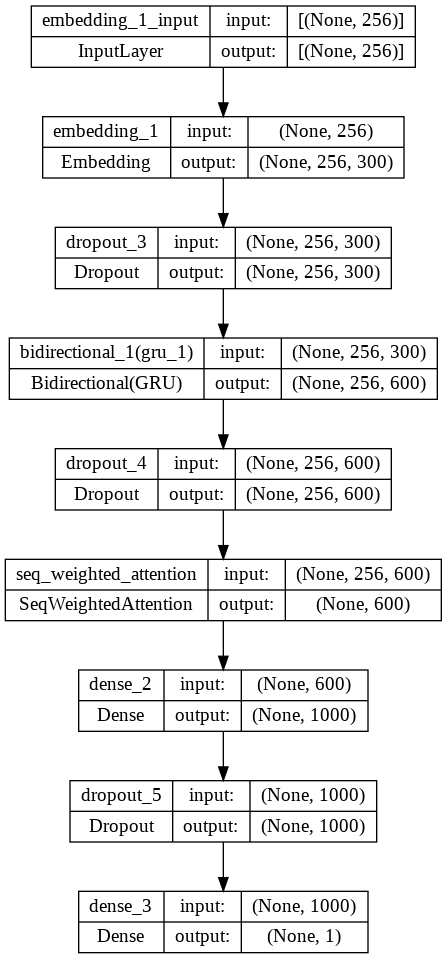

In [ ]:
from keras.utils.vis_utils import plot_model
from IPython.display import Image

plot_model(model2, show_shapes = True, show_layer_names = True, to_file = 'model.png')

Image(retina = True, filename = 'model.png')

### Run predictions and generate plots/metrics using the best model

1532/1532 [==============================] - 372s 241ms/step
Scores for each class
Precision score for class 0: 0.8139 & Precision score for class 1: 0.8206
Recall score for class 0: 0.7541 & Recall score for class 1: 0.8671
F1 score for class 0: 0.7829 & F1 score for class 1: 0.8432
AUC score for each class 0.8106
---------------------
Macro-averaged scores
Precision score: 0.8173
Recall score: 0.8106
F1 score: 0.813
AUC score: 0.8106
              precision    recall  f1-score   support

           0       0.81      0.75      0.78     21330
           1       0.82      0.87      0.84     27664

    accuracy                           0.82     48994
   macro avg       0.82      0.81      0.81     48994
weighted avg       0.82      0.82      0.82     48994


657/657 [==============================] - 154s 234ms/step
Scores for each class
Precision score for class 0: 0.7263 & Precision score for class 1: 0.7567
Recall score for class 0: 0.6633 & Recall score for class 1: 0.8073
F1 score 

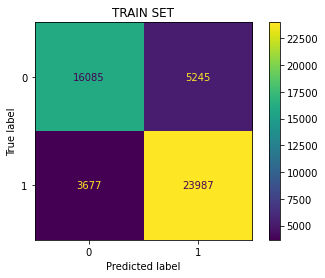

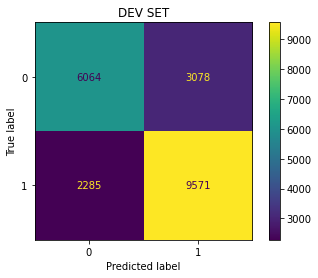

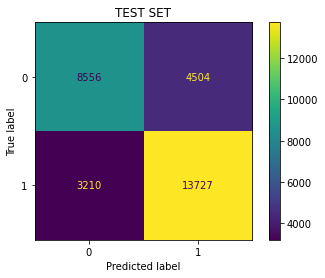

In [ ]:
all_scores(model2, train_data, y_train.to_numpy(), "TRAIN SET")
all_scores(model2, dev_data, y_dev.to_numpy(), "DEV SET")
all_scores(model2, test_data, y_test.to_numpy(), "TEST SET")